## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


%run nb_init
# This imports leg_joint as lj


/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1340: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)
2015-08-23 19:30:11,307 -leg_joint -INFO -successfully imported leg_joint


# Parameter management

Although the core paramter of the tissue are stored in an xml file, the paramters for the leg joint formation simulation
are stored as a json file and implemented in dictionaries.



In [2]:
params =  {## parameters to retrieve the apoptotic cells sequence
           'seq_kwargs': {'num_cells': 1., ## The number of apoptotic cells
                          'width_apopto':2, ## The width of the apoptotic ring
                          'amp': 0.4, ## Aplitude of the dorsal/ventral bias
                          'seed': 10, ## Seed for the random number generator
                          'num_steps': 10, ## Number of subsequent steps for one cell to complete apoptosis},
                          'random': True}, ## If True, (biased) random distrbution of apoptotic cells
           ## paramters for the dynamic of each apoptotic step
           'apopto_kwargs': {'vol_reduction':0.7, ## Cell volume reduction
                             'contractility': 1.2, ## Cell increase in contractility
                             'radial_tension': 0.1}, ## Increase n amplitude of the apico-basal force
           ## paramters for the increase in contractility after apoptosis
           'post_kwargs': {'max_ci':2., ## Maximum value of the contractility of the neighbouring cells 
                           'rate_ci':1., ## Rate at whihc contractility increase
                           'span_ci':2}, ## Span of the contractility increase (in terms of distance w/r to the apoptotic cell)
           }


In [3]:
all_kwargs = lj.get_list_kwargs(0, params)

## Simulation

#### Initialisation

Grab an epithelium

In [4]:
eptm = lj.Epithelium(lj.data.before_apoptosis_xml(),
                     save_dir='saved_graphs',
                     identifier='single',
                     copy=True)
eptm.isotropic_relax()

2015-08-23 19:30:33,973 -leg_joint.epithelium -INFO -Instanciating epithelium single
2015-08-23 19:30:35,520 -leg_joint.epithelium -INFO -Initial cells
2015-08-23 19:30:35,521 -leg_joint.epithelium -INFO -Initial junctions
2015-08-23 19:30:42,319 -leg_joint.epithelium -INFO -Update geometry


and get apoptic cells sequence (here only one cell will die)

In [5]:
seq_kwargs = all_kwargs['seq_kwargs']
apopto_kwargs = all_kwargs['apopto_kwargs']
post_kwargs = all_kwargs['post_kwargs']

apopto_cells, fold_cells, apopto_sequence = lj.get_apoptotic_cells(eptm, **seq_kwargs)

print('%i apoptotic cell(s)' % len(apopto_cells))
print('surrounded by %i fold cell(s)' % len(fold_cells))


1 apoptotic cell(s)
surrounded by 157 fold cell(s)


Now grab our apoptotic cell, and have a look at it's surroundings

In [6]:
apopto_kwargs

{'contractility': 1.2, 'radial_tension': 0.1, 'vol_reduction': 0.7}

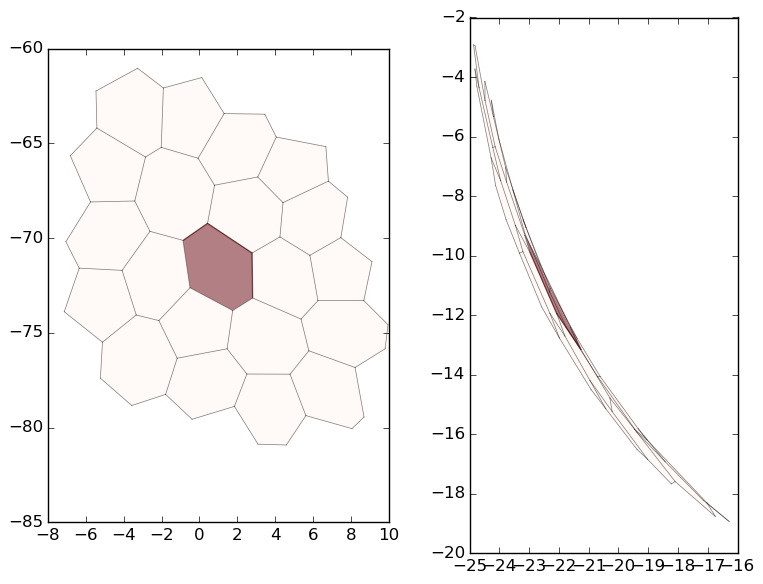

In [29]:
a_cell = apopto_cells[0]
eptm.set_local_mask(None)
eptm.set_local_mask(a_cell, wider=True)
neighbours = [neighbour for neighbour in eptm.cells.get_neighbor_cells(a_cell)]

## Let's define a neat plotting function
def show_apopto_surroundings(eptm, a_cell):
    eptm.set_local_mask(None)
    eptm.set_local_mask(a_cell, wider=True)
    is_apoptotic = eptm.ixs.copy()
    is_apoptotic.a[:] = 0.
    is_apoptotic[a_cell] = 1.
    ax_zs, ax_xy = lj.plot_2pannels(eptm,
                                    edge_kwargs={'c':'k', 'lw':0.5, 'alpha':0.5},
                                    cell_kwargs={'cell_colors':is_apoptotic,
                                                 'cmap':'Reds',
                                                 'alpha':0.5})

    eptm.set_local_mask(None)
    return ax_zs, ax_xy

### And use it straight away
ax_zs, ax_xy = show_apopto_surroundings(eptm, a_cell)

### First step of the simulation

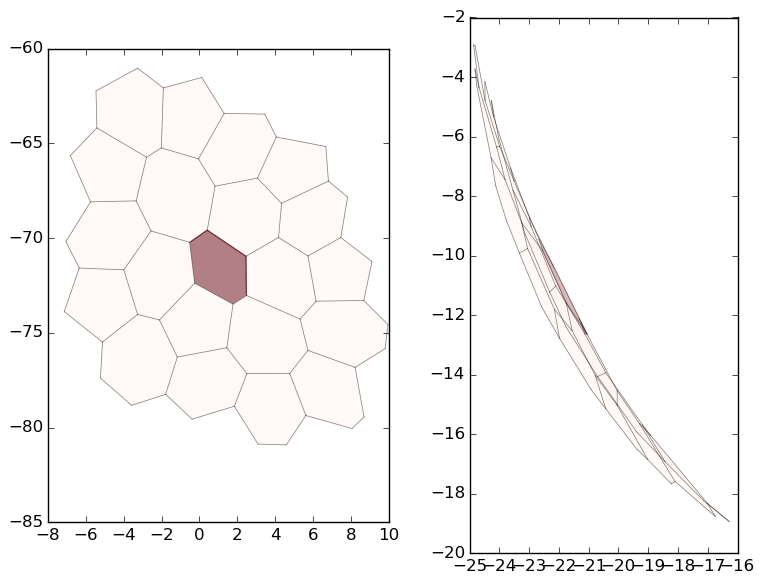

In [30]:
lj.apoptosis_step(eptm, a_cell, **apopto_kwargs)

ax_zs, ax_xy = show_apopto_surroundings(eptm, a_cell)

Now let's do the above repeatidly

We did 11 steps


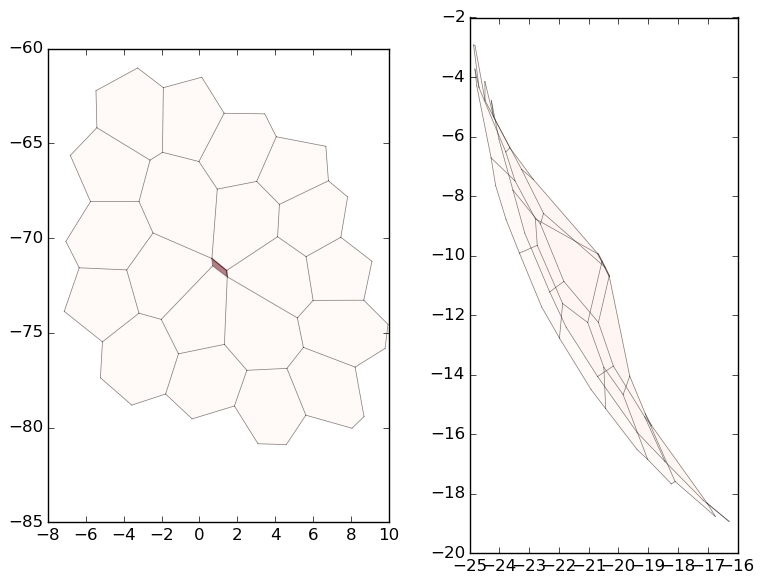

In [31]:
steps = 1
for sub_sequence in apopto_sequence:
    for a_cell in sub_sequence:
        lj.apoptosis_step(eptm, a_cell, **apopto_kwargs)
        steps += 1
print('We did %i steps' % steps)
#new_jv = remove_cell(eptm, prev_first)
ax_zs, ax_xy = show_apopto_surroundings(eptm, a_cell)

In [32]:
eptm.paths

{'png': '/home/guillaume/Python/leg-joint/notebooks/saved_graphs/single/png',
 'pdf': '/home/guillaume/Python/leg-joint/notebooks/saved_graphs/single/pdf',
 'json': 'saved_graphs/single/params_single_2014-06-12T15_56_36.json',
 'root': '/home/guillaume/Python/leg-joint/notebooks/saved_graphs/single',
 'hdf': '/home/guillaume/Python/leg-joint/notebooks/saved_graphs/single/eptm_single_2014-06-12T15_56_36.h5',
 'xml': '/home/guillaume/Python/leg-joint/notebooks/saved_graphs/single/xml',
 'log': 'saved_graphs/single/single_2014-06-12T15_56_36.log',
 'svg': '/home/guillaume/Python/leg-joint/notebooks/saved_graphs/single/svg'}

In [34]:
eptm.graph.save(os.path.join(eptm.paths['xml'], 'before_elimination.xml'))

In [44]:
lj.post_apoptosis(eptm, a_cell, fold_cells, **post_kwargs)

2014-06-03 18:34:51,853 -leg_joint.epithelium -INFO -new vertex 5123


In [45]:
eptm.graph.save(os.path.join(eptm.paths['xml'], 'after_elimination.xml'))

In [15]:
lj.running_local_optimum(eptm, tol=1e-3)

In [34]:
eptm.set_local_mask(None)
for neighbour in neighbours:
    eptm.set_local_mask(neighbour, wider=True)

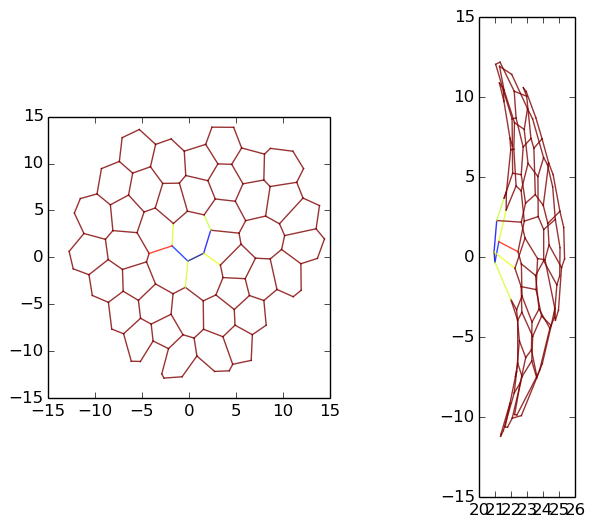

In [40]:
eptm.graph.set_edge_filter(eptm.is_local_edge)
eptm.update_rhotheta()
depth = eptm.dzeds.copy()
    
for edge in eptm.graph.edges():
    depth[edge] = (eptm.rhos[edge.source()]
                       + eptm.rhos[edge.target()]) / 2.
depth.a -= depth.fa.min()
eptm.graph.set_edge_filter(None)

axes = lj.plot_2pannels(eptm, 
                        cell_kwargs={'c_text':False},
                        edge_kwargs={'edge_color':depth, 'alpha':0.8})